# CoNIC Data and Statistics

## About this notebook
In this jupyter notebook, we show how users can read data provided in the CoNIC challenge and provide some dataset statistics.

### Importing related libraries

We import some some standard Python modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import cv2
import sys

sys.path.append("../")
from misc.utils import remap_label

mpl.rcParams['figure.dpi'] = 120 # for high resolution figure in notebook

### Data Reading

First, let's provide the path to all data provided as part of the challenge.

In [2]:
data_root = "../data" #! Change this according to the root path where the data is located

images_path = "%s/images.npy" % data_root # images array Nx256x256x3
labels_path = "%s/labels.npy" % data_root # labels array Nx256x256x3
counts_path = "%s/counts.csv" % data_root # csv of counts per nuclear type for each patch
info_path = "%s/patch_info.csv" % data_root # csv indicating which image from Lizard each patch comes from

Now let's load in each of the files!

In [3]:
images = np.load(images_path)
labels = np.load(labels_path)
counts = pd.read_csv(counts_path)
patch_info = pd.read_csv(info_path)

Let's take a look at the dimensions of the path data

In [4]:
print("Images Shape:", images.shape)
print("Labels Shape:", labels.shape)

Images Shape: (4981, 256, 256, 3)
Labels Shape: (4981, 256, 256, 2)


As can be seen, both arrays have 4 dimensions. Specifically, the dimensions are NxHxWxC. Here, N is the number of patches, H and W are the patch dimensions and C is the number of channels. Therefore, in CoNIC we provide 4981 patches. The imges are RGB (hence 3 channels), whereas for the labels, the first channel is the instance map and the second channel is the classification map.

Let's visualise a few patches along with the coresponding ground truth.

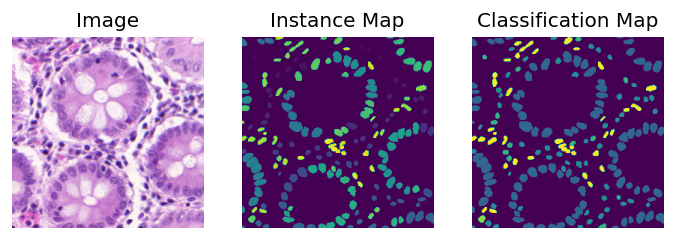

In [5]:
# this patch can be repeatedly executed to visualise a different patch!
rand_idx = np.random.randint(0, images.shape[0]) # select a random patch
patch_img = images[rand_idx] # 256x256x3
patch_lab = labels[rand_idx] # 256x256x2

# separate the instance map and classification map
patch_inst_map = patch_lab[..., 0]
patch_class_map = patch_lab[..., 1]

# visualise the data in a single plot
viz_dict = {"Image": patch_img, "Instance Map": patch_inst_map, "Classification Map": patch_class_map}
fig = plt.figure(figsize=(7,10))
count = 1
for img_name, img in viz_dict.items():
  ax = plt.subplot(1,3, count)
  plt.imshow(img)
  plt.title(img_name)
  plt.axis("off")
  count += 1

As can be seen above, the instance map uniquely labels each nucleus and the classification map labels each nucleus according the category it belongs to. In particular, the class mapping of values in the classification map is as follows:

- 0: background
- 1: neutrophil
- 2: epithelial
- 3: lymphocyte
- 4: plasma
- 5: eosinophil
- 6: connective

Connective tissue cells is a category that encompasses fibroblasts, muscle cells and endothelial cells. Below, we can transform the instance map and classification map so that we have 6 instance maps- one for each class.

In [6]:
patch_inst_map_perclass = [] 

# iterate over the classes
for i in range(6):
    # only consider one class within classification map
    class_map_tmp = patch_class_map == i+1
    # subset the instance map
    inst_map_tmp = patch_inst_map * class_map_tmp
    # convert the instance map so that the nuclei values are contiguous
    unique_vals = np.unique(inst_map_tmp).tolist()
    if len(unique_vals) > 1:
        inst_map_tmp = remap_label(inst_map_tmp)
    patch_inst_map_perclass.append(inst_map_tmp)

# convert list to numpy array
patch_inst_map_perclass = np.dstack(patch_inst_map_perclass) # shape 256x256x6

Now, let's visualise the instance maps per class

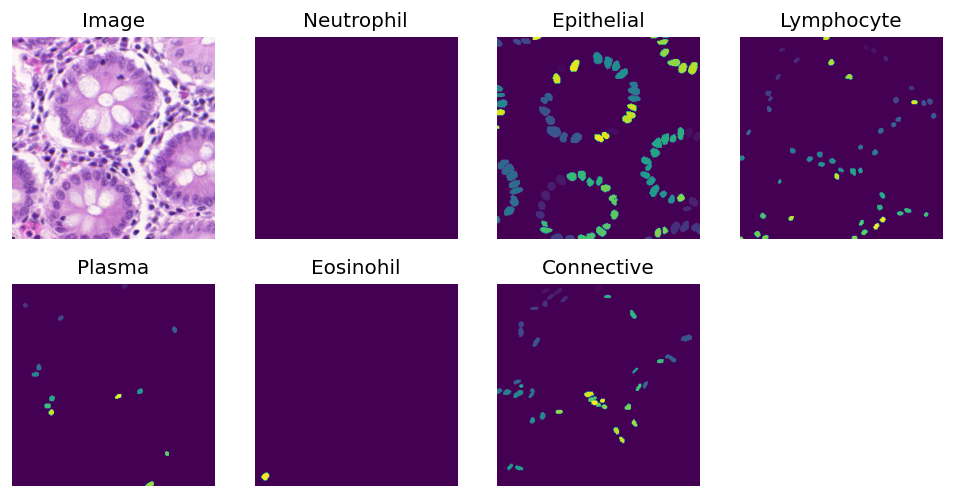

In [7]:
# visualise the data in a single plot, including the original patch
class_names = ["Neutrophil", "Epithelial", "Lymphocyte", "Plasma", "Eosinohil", "Connective"]

fig = plt.figure(figsize=(10,5))
for idx in range(7):
  ax = plt.subplot(2,4, idx+1)
  if idx == 0:
      plt.imshow(patch_img)
      plt.title("Image")
  else:
    plt.imshow(patch_inst_map_perclass[..., idx-1])
    plt.title(class_names[idx-1])
  plt.axis("off")

Now that we have visualised the patches, let's take a look at the counts per class for each patch. First let's take a look at the first rows of `counts.csv`.

In [8]:
# print the first 5 rows
print(counts.head()) 

   neutrophil  epithelial  lymphocyte  plasma  eosinophil  connective
0           0         117           0       0           0           0
1           0          95           1       0           0           8
2           0         172           3       0           0           2
3           0          56           0       0           0          10
4           0         169           7       0           0           0


As can be seen, the column names refer to each nuclear type and each row corresponds to a unique patch. Therefore a given cell corresponds to the number of nuclei of a certain type within a single input patch. It is important to note that the ordering of the rows are consistent with the ordering of the numpy arrays.

Therefore, let's show an input patch and the corresponding count summary in the dataframe. For counting, we only consider the central 224x224 region. This is so that we only consider nuclei for counting if they are entirely (or at least mostly!) within the image. To show this, also plot the central region as a green box overlaid on top of the patch.

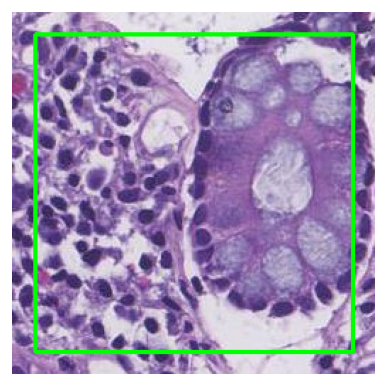

neutrophil     0
epithelial    22
lymphocyte    32
plasma        18
eosinophil     1
connective    14
Name: 3580, dtype: int64


In [9]:
# in the same way as before, let's get a random patch
rand_idx = np.random.randint(0, images.shape[0]) # select a random patch
patch_img = images[rand_idx] # 256x256x3

# for counting, we only consider the central 224x224 region. Let's draw a box to show this region
patch_img_box = cv2.rectangle(patch_img.copy(), (16,16), (240,240), (0,255,0), 2)

# now let's get the corresponding count information in the csv
patch_counts = counts.iloc[rand_idx]

plt.imshow(patch_img_box)
plt.axis("off")
plt.show()

print(patch_counts)


We provide `patch_info.csv` so that participants now which images in the Lizard dataset patches originate from. This may also be useful information when creating the data split for training the model. Let's have a look at this file!

In [10]:
# print the first 5 rows
print(patch_info.head()) 

       patch_info
0   consep_1-0000
1   consep_1-0001
2   consep_1-0002
3   consep_1-0003
4  consep_10-0000


We can see from the above that the first 5 patches come from CoNSeP. Now, let's wrap it all together. For a random image patch, let's get the instance map, classification map, the counts and the data source. 


neutrophil     0
epithelial    91
lymphocyte    70
plasma         6
eosinophil     2
connective    43
Name: 4451, dtype: int64
patch_info    glas_31-0008
Name: 4451, dtype: object


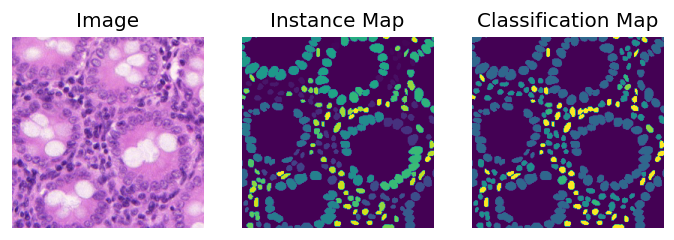

In [11]:
# this patch can be repeatedly executed to visualise a different patch!
rand_idx = np.random.randint(0, images.shape[0]) # select a random patch
patch_img = images[rand_idx] # 256x256x3
patch_lab = labels[rand_idx] # 256x256x2

# separate the instance map and classification map
patch_inst_map = patch_lab[..., 0]
patch_class_map = patch_lab[..., 1]

# now let's get the corresponding count information in the csv
patch_counts = counts.iloc[rand_idx]
patch_source = patch_info.iloc[rand_idx]

# visualise the data in a single plot
viz_dict = {"Image": patch_img, "Instance Map": patch_inst_map, "Classification Map": patch_class_map}
fig = plt.figure(figsize=(7,10))
count = 1
for img_name, img in viz_dict.items():
  ax = plt.subplot(1,3, count)
  plt.imshow(img)
  plt.title(img_name)
  plt.axis("off")
  count += 1
  
print(patch_counts)
print("="*30)
print(patch_source)

### Data Statistics

Now, let's compute some dataset statistics. Let's get the number of total nuclei in the dataset and the number of nuclei considered for counting. First, we will look at the total nuclei per class from the instance maps.

In [12]:
# counts from instance map
inst_map = labels[..., 0]
class_map = labels[..., 1]

total_nuclei = 0
total_neutrophil = 0
total_epithelial = 0
total_lymphocyte = 0
total_plasma = 0
total_eosinophil = 0
total_connective = 0
class_names = ["Neutrophil", "Epithelial", "Lymphocyte", "Plasma", "Eosinohil", "Connective"]
total_list = [total_neutrophil, total_epithelial, total_lymphocyte, total_plasma, total_eosinophil, total_connective]
for idx in range(inst_map.shape[0]):
    patch_inst_map = inst_map[idx]
    patch_class_map = class_map[idx]
    unique_vals = np.unique(patch_inst_map).tolist()[1:]
    total_nuclei += len(unique_vals)
    # get the counts per class
    for idx2 in range(6):
        patch_class_map_oneclass = patch_class_map == idx2+1
        # subset the instance map
        patch_inst_map_oneclass = patch_inst_map * patch_class_map_oneclass
        unique_vals = np.unique(patch_inst_map_oneclass).tolist()[1:]
        total_list[idx2] += len(unique_vals)

for idx, class_name in enumerate(class_names):
    print(class_name, ":", total_list[idx])
    
print("Total :", total_nuclei)

Neutrophil : 5082
Epithelial : 282082
Lymphocyte : 120933
Plasma : 31965
Eosinohil : 3849
Connective : 125950
Total : 569861


You may notice that there exists more nuclei than in the original Lizard datset. Although we mainly use non-overlapping patches, we choose to extract with overlap at the edge of each image to ensure all pixels are considered without the need for padding. For further detail, we encourage participants to dig into the patch extraction code. 

Now, let's get a summary of the counts derived from the csv file.

In [13]:
# counts from counts.csv file

counts_neutrophil = 0
counts_epithelial = 0
counts_lymphocyte = 0
counts_plasma = 0
counts_eosinophil = 0
counts_connective = 0
for idx in range(counts.shape[0]):
    counts_tmp = counts.iloc[idx]
    counts_neutrophil += counts_tmp['neutrophil']
    counts_epithelial += counts_tmp['epithelial']
    counts_lymphocyte += counts_tmp['lymphocyte']
    counts_plasma += counts_tmp['plasma']
    counts_eosinophil += counts_tmp['eosinophil']
    counts_connective += counts_tmp['connective']

counts_list = [counts_neutrophil, counts_epithelial, counts_lymphocyte, counts_plasma, counts_eosinophil, counts_connective]
for idx, count_type in enumerate(counts_list):
    print(class_names[idx], ":", count_type)
    
counts_total = sum(counts_list)
print("Total :", counts_total)

Neutrophil : 4012
Epithelial : 222017
Lymphocyte : 93612
Plasma : 24793
Eosinohil : 2999
Connective : 98783
Total : 446216


As expected, there are less nuclei counted from the csv file because here, we only consider the central 224x224 region for counting. Finally, let's plot the distribution of classes in CoNIC. For this, we will just show the class count from the csv file.

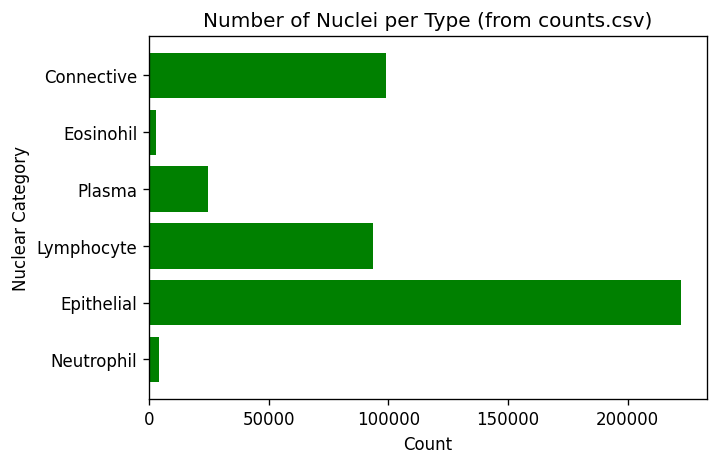

In [14]:
x_pos = [i for i, _ in enumerate(class_names)]

plt.barh(x_pos, counts_list, color='green')
plt.xlabel("Count")
plt.ylabel("Nuclear Category")
plt.title("Number of Nuclei per Type (from counts.csv)")
plt.yticks(x_pos, class_names)
plt.show()